# **Investor Insight: Analysis of New York City Housing Market**
<hr>

### Cohort B Team 1
### Team Members: Boyuan Zhang, Zheman Zhong, Yidan Xu, Tao Li

## **0. Table of Contents**

<hr>

### [1. Executive Summary](#section-title)
### [2.Project Proposal](#section-title)
### [3.Data Source](#section-title)
### [4.Initial Exploratory of Data](#section-title)
### [5.Detailed Analysis](#section-title)
### [6.Additional Analysis](#section-title)
### [7.Conclusion](#section-title)
### [8.Conclusion Summarized](#section-title)
### [9.Dashboard](#section-title)
### [10.Citation](#section-title)

## **1. Executive Summary**

<hr>

### The financial bubble created by the US housing market has been a dominant if not the sole reason for the world economy to collapse in 2008. In this project, we carefully analyze the housing data of New York City from 2003 to 2019 to recognize distinctive relationships between different building types and their price per square foot (psf.) We also look at the relationship between the age of the buildings and their psf to better understand how a building's value changes gradually as time goes by. We explore the issue of the volatilities of housing prices in different neighborhoods, and how "durable" each neighborhood's psf can be when financial disasters come. In the end, we have located for potential buyers the building types they should be purchasing, the building age they should be seeking, along with the neighborhoods that they should avoid of their high volatility and vulnerability in face of crisis.


## **2. Project Proposal**
<hr>

### Our goal is to analyze NYC’s housing data to better advise future real estate investors, developers, families or individuals seeking houses in NYC to make more informed decisions on acquiring new tangible assets. We aim to understand how building categories contribute to the selling prices of units in them, and how should buyers consider the age of the buildings before signing a contract. More importantly, we explore the issue of whether poorer neighborhoods gradually change into wealthier neighborhoods as time goes by (volitalities in prices), and the risk of owning a house in different neighborhoods when financial disaster comes. The main tool we use for this project is BigQuery powered by Google Cloud. 

## **3. Data Source**
<hr>

### **3.1 Raw Data:** __[NYC Finance Open Data](https://www1.nyc.gov/site/finance/taxes/property-rolling-sales-data.page)__
#### *The raw data is from New York City Department of Finance Open Source Data.* 
### **3.2 Data Used:** __[Kaggle.com/NYC Housing Data 2003-2019](https://www.kaggle.com/datasets/kaijiechen/nyc-housing-data-20032019)__
#### Author: __[Kaijie Chen](https://www.kaggle.com/kaijiechen)__
#### *Since the raw data is based on rolling sales by neighborhoods, it has been modified on kaggle.com by an actuary at an insurance company: Kaijie Chen. The data on kaggle.com now contains sales in all neighborhoods of NYC from 2003 to 2019.*
### **3.3 Additional Data:** 
__[Federal Reserve Economic Data on Total Construction Spending - Residential in the United States 
](https://fred.stlouisfed.org/series/TLRESCONS)__
__[Federal Reserve Economic Data on S&P/Case-Shiller U.S. National Home Price Index](https://fred.stlouisfed.org/series/CSUSHPISA)__
#### *We are including two additional datasets from Federal Reserve Economic Data (FRED) of the Federal Reserve Bank in St. Louis: Total Construction Spending on Residential Housing over years and Case_Shiller National Home Price Index (HPI) over years. HPI measures the value of single-family housing within the US.*


## **4. Initial Exploratory of Data**
<hr>

### **4.1 Checking the completeness of the data and counting unique neighborhoods:**

In [101]:
%%bigquery
SELECT DISTINCT NEIGHBORHOOD --selecting unique neighborhoods
FROM ba775-teamproject-b1.teamproject.nycdata;
#There appears to be some neighborhoods without names but with numbers. 

Downloading: 100%|██████████| 516/516 [00:00<00:00, 651.93rows/s] 


,NEIGHBORHOOD
0,ALPHABET CITY
1,CHELSEA
2,CIVIC CENTER
3,CLINTON
4,EAST VILLAGE
...,...
511,3004
512,VAN CORTLANDT PARK
513,3019
514,1021


In [102]:
%%bigquery
SELECT DISTINCT NEIGHBORHOOD
FROM  ba775-teamproject-b1.teamproject.nycdata
WHERE NEIGHBORHOOD NOT LIKE '%0%'
AND NEIGHBORHOOD NOT LIKE '%1%'
AND NEIGHBORHOOD NOT LIKE '%2%'
AND NEIGHBORHOOD NOT LIKE '%3%'
AND NEIGHBORHOOD NOT LIKE '%4%'
AND NEIGHBORHOOD NOT LIKE '%5%'
AND NEIGHBORHOOD NOT LIKE '%6%'
AND NEIGHBORHOOD NOT LIKE '%7%'
AND NEIGHBORHOOD NOT LIKE '%8%'
AND NEIGHBORHOOD NOT LIKE '%9%'; --Excluding all neighborhoods with no names with numbers. 
#The generated table shows only neighborhoods with names. 

Downloading: 100%|██████████| 500/500 [00:01<00:00, 436.18rows/s]


,NEIGHBORHOOD
0,ALPHABET CITY
1,CHELSEA
2,CIVIC CENTER
3,CLINTON
4,EAST VILLAGE
...,...
495,CITY ISLAND-PELHAM STRIP
496,GREAT KILLS-BAY TERRACE
497,DONGAN HILLS-OLD TOWN
498,BREEZY POINT


In [103]:
%%bigquery
SELECT COUNT(DISTINCT NEIGHBORHOOD) AS Neighbor_Count --counting unique neighborhoods
FROM ba775-teamproject-b1.teamproject.nycdata
WHERE NEIGHBORHOOD NOT LIKE '%0%'
AND NEIGHBORHOOD NOT LIKE '%1%'
AND NEIGHBORHOOD NOT LIKE '%2%'
AND NEIGHBORHOOD NOT LIKE '%3%'
AND NEIGHBORHOOD NOT LIKE '%4%'
AND NEIGHBORHOOD NOT LIKE '%5%'
AND NEIGHBORHOOD NOT LIKE '%6%'
AND NEIGHBORHOOD NOT LIKE '%7%'
AND NEIGHBORHOOD NOT LIKE '%8%'
AND NEIGHBORHOOD NOT LIKE '%9%'; 
#There are 500 different neighborhoods in NYC that are unique and with names. 

Downloading: 100%|██████████| 1/1 [00:01<00:00,  1.06s/rows]


,Neighbor_Count
0,500


### **4.2 Since Gross Square Feet, Sale Price, Year Built and Building Class Category are the most important variables in our analysis, we begin to check for null values in all of the selected variables:**

In [104]:
%%bigquery
SELECT ADDRESS, GROSS_SQUARE_FEET
FROM  ba775-teamproject-b1.teamproject.nycdata 
WHERE GROSS_SQUARE_FEET IS NULL
LIMIT 5; --only shows the first 5 null values 
#There are null values in gross_square_feet, so we will only analyze buildings with gross square feet larger than 1. 

Downloading: 100%|██████████| 5/5 [00:01<00:00,  4.62rows/s]


,ADDRESS,GROSS_SQUARE_FEET
0,156 WILLIAM STREET,NaN
1,"762 MARCY AVENUE, 1B",NaN
2,"762 MARCY AVENUE, 4",NaN
3,94 NORTH 3RD STREET,NaN
4,21-17 31ST AVENUE,NaN


In [105]:
%%bigquery
SELECT ADDRESS, SALE_PRICE
FROM ba775-teamproject-b1.teamproject.nycdata
WHERE SALE_PRICE = 0
LIMIT 5; --only shows the first 5 null values
#There are sale prices equal to $0, which suggests that there are buildings that were never sold.
#We will only analyze buildings with sale price larger than $0 
#(Considering there will be buildings that may be gifted for a very low price)

Downloading: 100%|██████████| 5/5 [00:01<00:00,  4.59rows/s]


,ADDRESS,SALE_PRICE
0,645 EAST 11 STREET,0
1,645 EAST 11 STREET,0
2,226-32 WEST 26 STREET,0
3,532 WEST 25 STREET,0
4,114-20 WEST 26 STREET,0


In [106]:
%%bigquery
SELECT ADDRESS, YEAR_BUILT
FROM ba775-teamproject-b1.teamproject.nycdata
WHERE YEAR_BUILT = 0
LIMIT 5; --only shows the first 5 null values
#There are year built values equal to 0, suggesting there are data with incomplete year of establishment. 
#Therefore we will only analyze buildings with year_built larger than 1492 (considering Christopher Columbus found America in 1492.) 

Downloading: 100%|██████████| 5/5 [00:01<00:00,  3.64rows/s]


,ADDRESS,YEAR_BUILT
0,331 EAST 8 STREET,0.0
1,237 WEST 26 STREET,0.0
2,107 WEST 26 STREET,0.0
3,22 WARREN STREET,0.0
4,58-60 READE STREET,0.0


In [107]:
%%bigquery
SELECT ADDRESS, BUILDING_CLASS_CATEGORY
FROM ba775-teamproject-b1.teamproject.nycdata
WHERE BUILDING_CLASS_CATEGORY IS NULL
#There are no null values in building class category. 
#However, there are duplicates of the same category due to spacing error (probably made when entering the data).
#We will solve this problem when we create a new table in 4.3. 

Query complete after 0.00s: 100%|██████████| 1/1 [00:00<00:00, 977.92query/s] 
Downloading: 0rows [00:00, ?rows/s]


,ADDRESS,BUILDING_CLASS_CATEGORY


### **4.3 Creating a new table processed_data from nycdata excluding all the null values found in 4.1 and 4.2.**

In [108]:
%%bigquery
CREATE OR REPLACE TABLE ba775-teamproject-b1.teamproject.processed_data AS 
SELECT BOROUGH, NEIGHBORHOOD, CATEGORY_NO_SPACE AS BUILDING_CLASS_CATEGORY, ADDRESS, ZIP_CODE, LAND_SQUARE_FEET, 
        GROSS_SQUARE_FEET, YEAR_BUILT, SALE_PRICE, SALE_DATE
FROM(
SELECT *, REPLACE(BUILDING_CLASS_CATEGORY, ' ', '') AS CATEGORY_NO_SPACE --remove duplicates caused by spacing error
FROM ba775-teamproject-b1.teamproject.nycdata
WHERE BUILDING_CLASS_CATEGORY IS NOT NULL
AND GROSS_SQUARE_FEET > 1.0   -- some are extremely low to 1, which make the price per sqaure too high
AND SALE_PRICE > 0.0  -- excludes buildings that were never sold
AND YEAR_BUILT > 1492 -- excludes some input error (e.g. house's built year is 1000)
AND NEIGHBORHOOD NOT LIKE '%0%'
AND NEIGHBORHOOD NOT LIKE '%1%'
AND NEIGHBORHOOD NOT LIKE '%2%'
AND NEIGHBORHOOD NOT LIKE '%3%'
AND NEIGHBORHOOD NOT LIKE '%4%'
AND NEIGHBORHOOD NOT LIKE '%5%'
AND NEIGHBORHOOD NOT LIKE '%6%'
AND NEIGHBORHOOD NOT LIKE '%7%'
AND NEIGHBORHOOD NOT LIKE '%8%'
AND NEIGHBORHOOD NOT LIKE '%9%'); 
#A new table: processed_data is therefore created, which is used in later analysis.

Query complete after 0.00s: 100%|██████████| 3/3 [00:00<00:00, 1109.51query/s]                        


""


### **Initial Exploratory of Data is COMPLETED.**
<br>

## **5. Detailed Analysis**
<hr>

### **5.1 How do the types of buildings affect their average selling price per square footage?**
#### ***(Are there building types with a significantly higher average price per square footage?)***

In [109]:
%%bigquery psf_building
SELECT  BUILDING_CLASS_CATEGORY, 
        ROUND(AVG(SALE_PRICE/GROSS_SQUARE_FEET)) AS price_per_square
FROM ba775-teamproject-b1.teamproject.processed_data
GROUP BY BUILDING_CLASS_CATEGORY
ORDER BY price_per_square DESC
LIMIT 5;  --There are 49 categories in total, 
          --Keep the first 10 with the highest average price per sqaure. 
#From the first 5 categories, we can roughly tell that buildings of tax classes and condos are relatively more expensive compared to other categories. 
#It appears that buildings with specific tax classes and commercial buildings enjoy a higher selling price per square foot.

Downloading: 100%|██████████| 5/5 [00:01<00:00,  3.88rows/s]


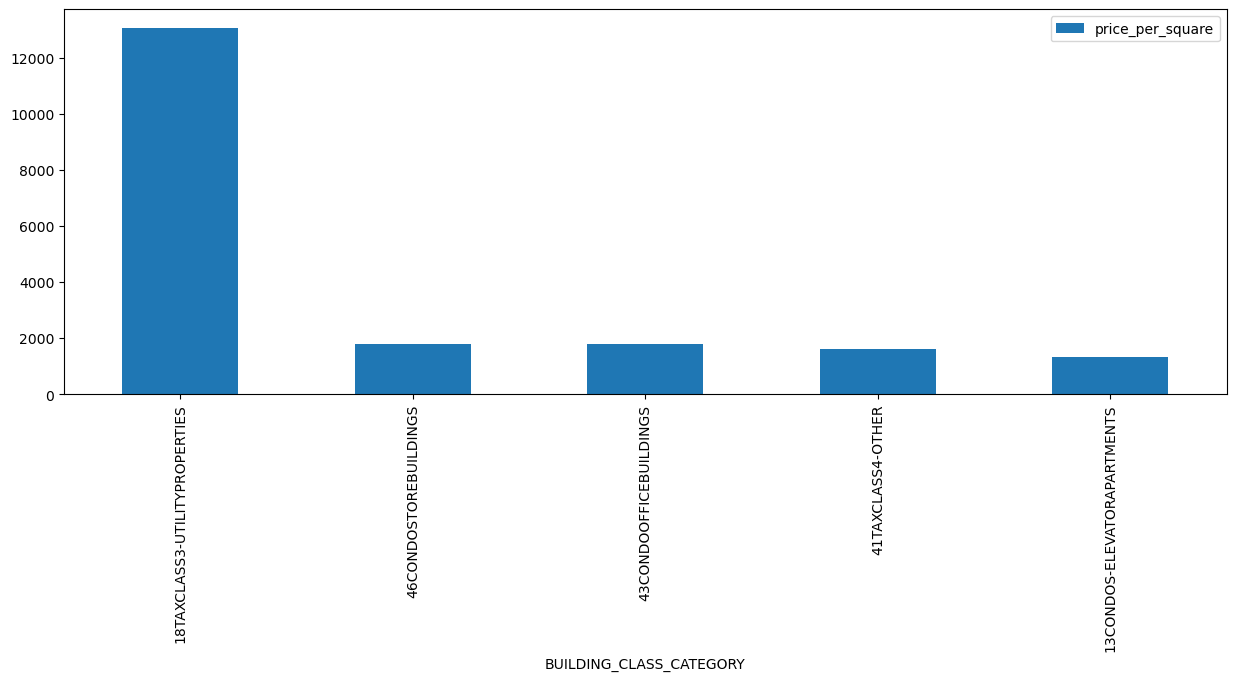

In [110]:
#We graph the first 5 categories with the highest average price per square
psf_building.plot(kind='bar', x='BUILDING_CLASS_CATEGORY', y='price_per_square', figsize=(15, 5));

### ***5.1 Findings:***
    - Tax Class 3: Utility Properties appear to have a significantly higher average selling price per square footage. 
    - The first 5 categories that have the largest average selling price per square footage are: Tax Class 3: Utility Properties, Condo Store Buildings, Condo Office Buildings, Tax Class 4: Others, and Condos: Elevator Apartments.

### **5.1a From the previous question, out of the first 20 categories of buildings with the highest average selling price per square, how many are condos, facilities, tax class (tax), hotel, and warehouse related?**

In [111]:
%%bigquery

WITH building_price AS
(SELECT BUILDING_CLASS_CATEGORY, 
        ROUND(AVG(SALE_PRICE/GROSS_SQUARE_FEET)) AS price_per_square
FROM ba775-teamproject-b1.teamproject.processed_data
GROUP BY BUILDING_CLASS_CATEGORY
ORDER BY price_per_square DESC
LIMIT 20)

SELECT ROUND((tot_number/20),4) AS PCT, BUILDING_CLASS_CATEGORY
FROM 
(SELECT BUILDING_CLASS_CATEGORY, COUNT(BUILDING_CLASS_CATEGORY) OVER() tot_number
FROM building_price
WHERE BUILDING_CLASS_CATEGORY LIKE "%CONDO%"
UNION ALL
SELECT BUILDING_CLASS_CATEGORY, COUNT(BUILDING_CLASS_CATEGORY) OVER() tot_number
FROM building_price
WHERE BUILDING_CLASS_CATEGORY LIKE "%FACILITIES%"
UNION ALL 
SELECT BUILDING_CLASS_CATEGORY, COUNT(BUILDING_CLASS_CATEGORY) OVER() tot_number
FROM building_price
WHERE BUILDING_CLASS_CATEGORY LIKE "%TAX%"
UNION ALL 
SELECT BUILDING_CLASS_CATEGORY, COUNT(BUILDING_CLASS_CATEGORY) OVER() tot_number
FROM building_price
WHERE BUILDING_CLASS_CATEGORY LIKE "%HOTEL%"
UNION ALL 
SELECT BUILDING_CLASS_CATEGORY, COUNT(BUILDING_CLASS_CATEGORY) OVER() tot_number
FROM building_price
WHERE BUILDING_CLASS_CATEGORY LIKE "%WAREHOUSE%"
)
ORDER BY PCT DESC
;
#Now we get, out of the first 20 categories with the highest average selling price per square , how many categories (in percentage) are related to general terms such as "condo", "facilities" etc. 
#We begin to create a new table category_pct to graph  

Downloading: 100%|██████████| 17/17 [00:01<00:00, 14.51rows/s]


,PCT,BUILDING_CLASS_CATEGORY
0,0.50,46CONDOSTOREBUILDINGS
1,0.50,42CONDOCULTURAL/MEDICAL/EDUCATIONAL/ETC
2,0.50,13CONDOS-ELEVATORAPARTMENTS
3,0.50,45CONDOHOTELS
4,0.50,43CONDOOFFICEBUILDINGS
5,0.50,44CONDOPARKING
6,0.50,12CONDOS-WALKUPAPARTMENTS
7,0.50,28COMMERCIALCONDOS
8,0.50,15CONDOS-2-10UNITRESIDENTIAL
9,0.50,11ACONDO-RENTALS


In [112]:
%%bigquery
--creating a new table for above
CREATE OR REPLACE TABLE ba775-teamproject-b1.teamproject.category_pct
(
 Category string, 
 Percentage float64
);
INSERT INTO ba775-teamproject-b1.teamproject.category_pct (Category, Percentage)
VALUES ('Condo', 0.5), ('Facility', 0.2), ('Tax Class', 0.1),
       ('Hotel', 0.05), ('Warehouse', 0.0);

Query complete after 0.00s: 100%|██████████| 1/1 [00:00<00:00, 737.40query/s] 


""


In [113]:
%%bigquery category_pct
SELECT * 
FROM ba775-teamproject-b1.teamproject.category_pct
ORDER BY Percentage DESC;
#Selecting all data from the new category_pct table to graph below.

Downloading: 100%|██████████| 5/5 [00:01<00:00,  4.32rows/s]


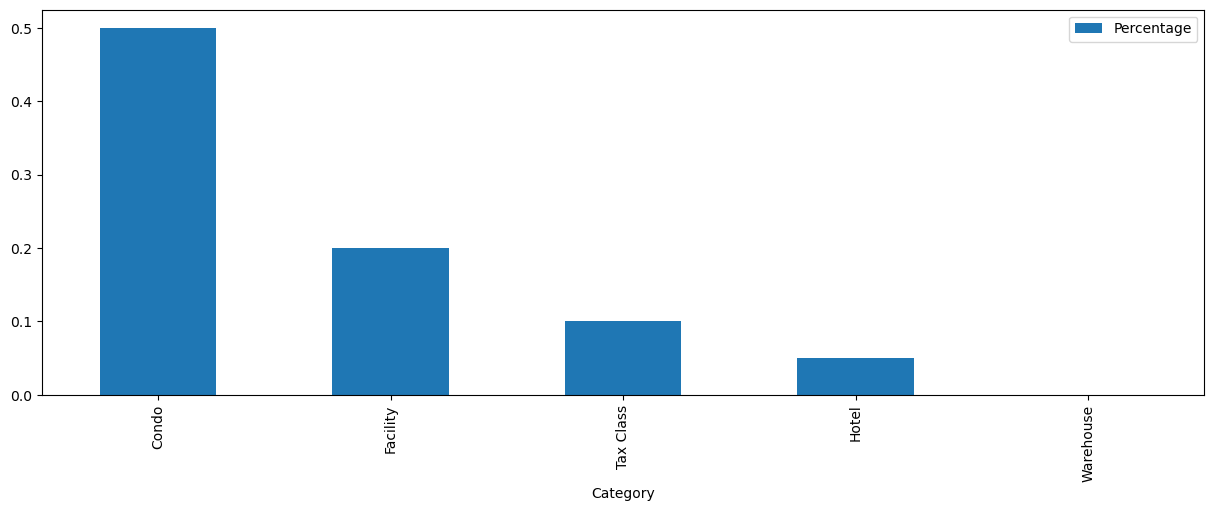

In [114]:
category_pct.plot(kind='bar', x='Category', y='Percentage', figsize=(15, 5));
#Please know that there is some overlapping between general terms selected as some categories contain multiple terms. (example: Tax Class: Condo)

### ***5.1a Finding:***
    - From the first 20 categories with the highest average selling price per square, 50% are realted to condos, 20% related to facilities, 10% related to tax class buildings, and 5% are related to hotels. 

### **5.1b Did any of the building type appreciated/depreciated from 2003 to 2019?**

In [115]:
%%bigquery app_or_dep
WITH condo AS(
SELECT  CAST(EXTRACT(YEAR FROM SALE_DATE) AS INT64) AS YEAR,  
        ROUND(AVG(SALE_PRICE/GROSS_SQUARE_FEET)) AS price_per_square
FROM ba775-teamproject-b1.teamproject.processed_data
WHERE BUILDING_CLASS_CATEGORY LIKE "%CONDO%"
GROUP BY YEAR
ORDER BY YEAR ASC), 

        facilities AS(
SELECT  CAST(EXTRACT(YEAR FROM SALE_DATE) AS INT64) AS YEAR,  
        ROUND(AVG(SALE_PRICE/GROSS_SQUARE_FEET)) AS price_per_square
FROM ba775-teamproject-b1.teamproject.processed_data
WHERE BUILDING_CLASS_CATEGORY LIKE "%FACILITIES%"
GROUP BY YEAR
ORDER BY YEAR ASC), 

       tax AS(
SELECT  CAST(EXTRACT(YEAR FROM SALE_DATE) AS INT64) AS YEAR,  
        ROUND(AVG(SALE_PRICE/GROSS_SQUARE_FEET)) AS price_per_square
FROM ba775-teamproject-b1.teamproject.processed_data
WHERE BUILDING_CLASS_CATEGORY LIKE "%TAX%"
GROUP BY YEAR
ORDER BY YEAR ASC), 

       hotel AS(
SELECT  CAST(EXTRACT(YEAR FROM SALE_DATE) AS INT64) AS YEAR,  
        ROUND(AVG(SALE_PRICE/GROSS_SQUARE_FEET)) AS price_per_square
FROM ba775-teamproject-b1.teamproject.processed_data
WHERE BUILDING_CLASS_CATEGORY LIKE "%HOTEL%"
GROUP BY YEAR
ORDER BY YEAR ASC), 

       warehouse AS(
SELECT  CAST(EXTRACT(YEAR FROM SALE_DATE) AS INT64) AS YEAR,  
        ROUND(AVG(SALE_PRICE/GROSS_SQUARE_FEET)) AS price_per_square
FROM ba775-teamproject-b1.teamproject.processed_data
WHERE BUILDING_CLASS_CATEGORY LIKE "%WAREHOUSE%"
GROUP BY YEAR
ORDER BY YEAR ASC)

SELECT condo.YEAR AS YEAR, 
        condo.price_per_square AS CONDO, 
        facilities.price_per_square AS FACILITIES, 
        tax.price_per_square AS TAX, 
        hotel.price_per_square AS HOTEL, 
        warehouse.price_per_square AS WAREHOUSE
FROM condo 
JOIN facilities ON condo.YEAR = facilities.YEAR
JOIN TAX ON tax.YEAR = facilities.YEAR
JOIN HOTEL ON hotel.YEAR = tax.YEAR
JOIN WAREHOUSE ON warehouse.YEAR = hotel.YEAR
ORDER BY YEAR ASC;

Downloading: 100%|██████████| 17/17 [00:01<00:00, 16.24rows/s]


<AxesSubplot:xlabel='YEAR'>

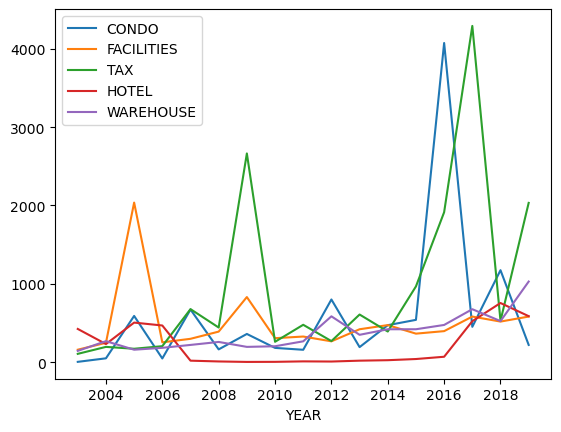

In [116]:
app_or_dep.plot(x = 'YEAR') 

### ***5.1b Findings:***
    - Condos, facilities, and tax class buildings appear to have potentials in appreciation from 2003 to 2019. 

### **5.2 How does a building’s age affect its selling price per square foot?** 
#### ***(Are there building classes with older/younger age enjoying higher selling prices per square foot?)*** 

In [117]:
%%bigquery price_of_building_class
SELECT (EXTRACT(YEAR FROM CURRENT_DATE()) - CAST(YEAR_BUILT AS INT)) AS building_age,  -- calculate the building age
        ROUND(AVG(SALE_PRICE/GROSS_SQUARE_FEET)) AS price_per_square  -- calculate the price per square
FROM ba775-teamproject-b1.teamproject.processed_data 
GROUP BY building_age
ORDER BY building_age, price_per_square DESC
#A plot can be structured here between age and price/square to see what trend they roughly follows. 

Downloading: 100%|██████████| 193/193 [00:01<00:00, 173.58rows/s]


<AxesSubplot:xlabel='building_age'>

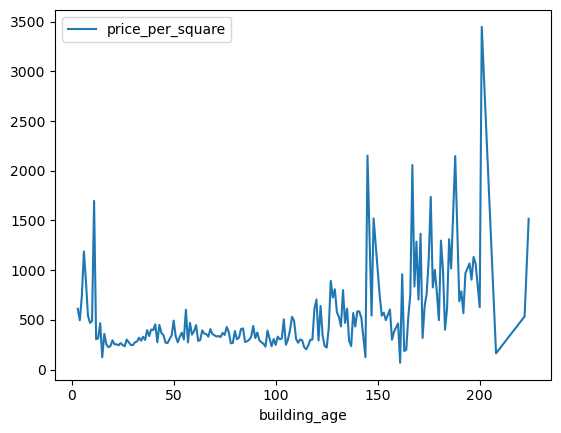

In [118]:
price_of_building_class.plot(x = 'building_age') 
#We could tell from the graph below that buildings have a relatively stable price per square feet between around age 10 to 110. 

### **5.2a Based on the question in 5.2, here we look at specific building types, how their age change with selling price per square foot.**

In [119]:
%%bigquery condo
SELECT building_age, ROUND(AVG(price_per_square)) AS avg_psf
FROM 
(SELECT (EXTRACT(YEAR FROM CURRENT_DATE()) - CAST(YEAR_BUILT AS INT)) AS building_age, 
        ROUND(AVG(SALE_PRICE/GROSS_SQUARE_FEET)) AS price_per_square
FROM ba775-teamproject-b1.teamproject.processed_data 
WHERE BUILDING_CLASS_CATEGORY LIKE '%CONDO%'
GROUP BY BUILDING_CLASS_CATEGORY, building_age
ORDER BY building_age ASC) 
GROUP BY building_age
ORDER BY building_age ASC;

Downloading: 100%|██████████| 129/129 [00:01<00:00, 89.71rows/s] 


<AxesSubplot:xlabel='building_age'>

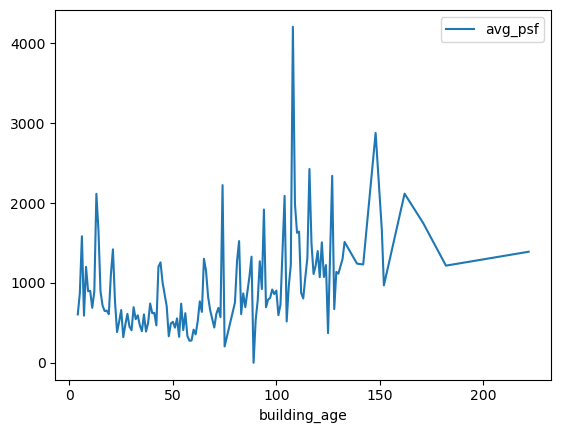

In [120]:
condo.plot(x = 'building_age') 
#Condos' price per square foot appear to be most stable between 23 to 42 years old. 

In [121]:
%%bigquery facility
SELECT building_age, ROUND(AVG(price_per_square)) AS avg_psf
FROM 
(SELECT (EXTRACT(YEAR FROM CURRENT_DATE()) - CAST(YEAR_BUILT AS INT)) AS building_age, 
        ROUND(AVG(SALE_PRICE/GROSS_SQUARE_FEET)) AS price_per_square
FROM ba775-teamproject-b1.teamproject.processed_data 
WHERE BUILDING_CLASS_CATEGORY LIKE '%FACILITIES%'
GROUP BY BUILDING_CLASS_CATEGORY, building_age
ORDER BY building_age ASC) 
GROUP BY building_age
ORDER BY building_age ASC;

Downloading: 100%|██████████| 129/129 [00:01<00:00, 102.66rows/s]


<AxesSubplot:xlabel='building_age'>

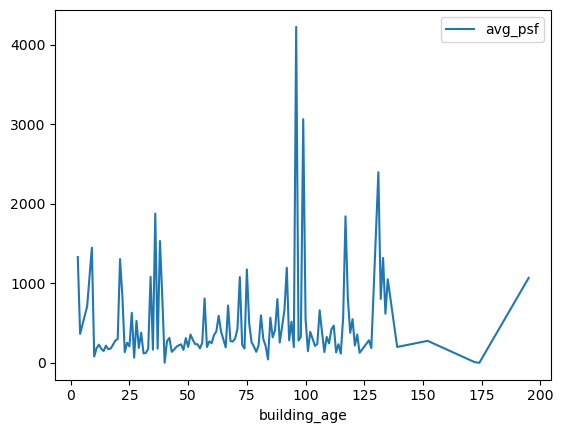

In [122]:
facility.plot(x = 'building_age') 
#Facilities' price per square foot appear to be most unpredictable, but relatively stable between 42 to 93 years old.

In [123]:
%%bigquery hotel
SELECT building_age, ROUND(AVG(price_per_square)) AS avg_psf
FROM 
(SELECT (EXTRACT(YEAR FROM CURRENT_DATE()) - CAST(YEAR_BUILT AS INT)) AS building_age, 
        ROUND(AVG(SALE_PRICE/GROSS_SQUARE_FEET)) AS price_per_square
FROM ba775-teamproject-b1.teamproject.processed_data 
WHERE BUILDING_CLASS_CATEGORY LIKE '%HOTEL%'
GROUP BY BUILDING_CLASS_CATEGORY, building_age
ORDER BY building_age ASC) 
GROUP BY building_age
ORDER BY building_age ASC;

Downloading: 100%|██████████| 77/77 [00:01<00:00, 61.91rows/s]


<AxesSubplot:xlabel='building_age'>

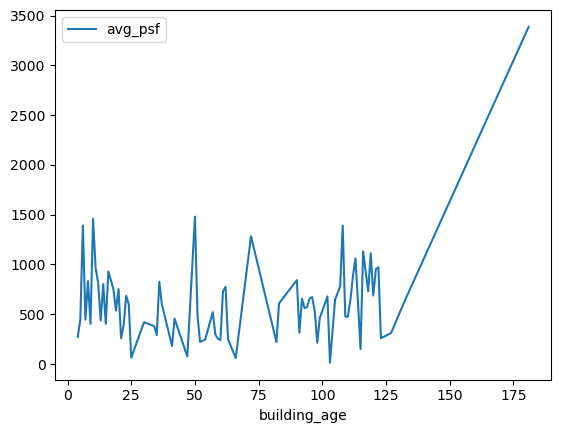

In [124]:
hotel.plot(x = 'building_age') 
#Hotels' price per square foot appear to be most stable between 25 to 47 years old.

In [125]:
%%bigquery warehouse
SELECT building_age, ROUND(AVG(price_per_square)) AS avg_psf
FROM 
(SELECT (EXTRACT(YEAR FROM CURRENT_DATE()) - CAST(YEAR_BUILT AS INT)) AS building_age, 
        ROUND(AVG(SALE_PRICE/GROSS_SQUARE_FEET)) AS price_per_square
FROM ba775-teamproject-b1.teamproject.processed_data 
WHERE BUILDING_CLASS_CATEGORY LIKE '%WAREHOUSE%'
GROUP BY BUILDING_CLASS_CATEGORY, building_age
ORDER BY building_age ASC) 
GROUP BY building_age
ORDER BY building_age ASC;

Downloading: 100%|██████████| 120/120 [00:01<00:00, 79.59rows/s] 


<AxesSubplot:xlabel='building_age'>

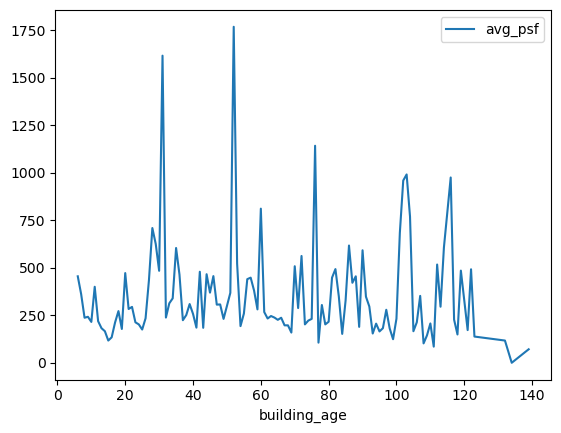

In [126]:
warehouse.plot(x = 'building_age') 
#Warehouses' price per square foot are volatile as the buildings age, but appear to be relatively stable between 32 to 50 years old.

In [127]:
%%bigquery tax
SELECT building_age, ROUND(AVG(price_per_square)) AS avg_psf
FROM 
(SELECT (EXTRACT(YEAR FROM CURRENT_DATE()) - CAST(YEAR_BUILT AS INT)) AS building_age, 
        ROUND(AVG(SALE_PRICE/GROSS_SQUARE_FEET)) AS price_per_square
FROM ba775-teamproject-b1.teamproject.processed_data 
WHERE BUILDING_CLASS_CATEGORY LIKE '%TAX%'
GROUP BY BUILDING_CLASS_CATEGORY, building_age
ORDER BY building_age ASC) 
GROUP BY building_age
ORDER BY building_age ASC;

Downloading: 100%|██████████| 104/104 [00:01<00:00, 98.64rows/s] 


<AxesSubplot:xlabel='building_age'>

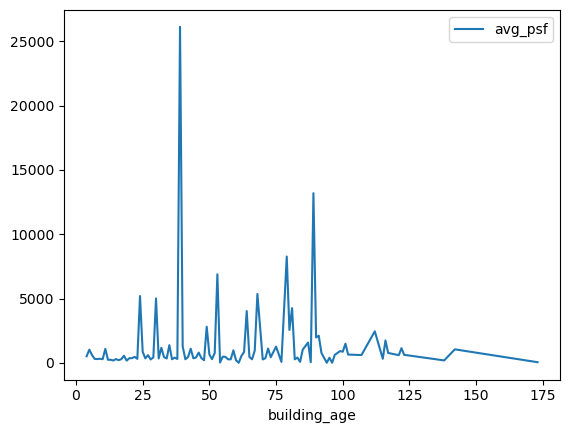

In [128]:
tax.plot(x = 'building_age')
#Tax Class' price per square foot are like Facilities. they appear to be most unpredictable, but relatively stable between 4 and 22 years old.

### ***5.2 & 5.2a Finding:***
    - From the analysis, as a general way of thumb, investor should look for buildings that are between 10 to 110 years old. 
    - In a case by case senario, if an investor is buying a: 
        - Condo, they should look at one between 25 to 55 years old. 
        - Hotel, they should look at one between 13 to 45 years old.
        - Warehouse, they should look at one between 30 to 50 years old, or younger than 25 years old.
        - Special case with Facility, they should look at one older than 95 years old.

### **5.3 Mapping the volatility of selling price per square foot in each neighborhood.**

In [129]:
%%bigquery
--We use the formula: Volitality = standard deviation of sale price change * square root of time period to calculate how volatile each neighborhood is. 
--First we calculate the standard deviation of sale price change: 
WITH std_table AS (
SELECT DISTINCT NEIGHBORHOOD, ZIP_CODE, SQRT(VAR) AS STD
FROM
(SELECT NEIGHBORHOOD, ZIP_CODE,
      VARIANCE(PRICE_PER_SQUARE) OVER(PARTITION BY NEIGHBORHOOD) AS VAR
FROM (
      SELECT *,
      CAST(SALE_PRICE AS NUMERIC)/GROSS_SQUARE_FEET AS PRICE_PER_SQUARE
      FROM ba775-teamproject-b1.teamproject.processed_data
      )
ORDER BY NEIGHBORHOOD, var DESC)),

--Secondly, we look at how long each neighborhood's time period is in which sales have taken place. 
      time_period_table as (
SELECT NEIGHBORHOOD, ROUND(EXTRACT(DAY FROM DIFF_IN_DAYS)/365, 2) AS DIFF_IN_YEARS
FROM
(SELECT NEIGHBORHOOD,
CAST(
      CONCAT(EXTRACT(YEAR FROM MAX(SALE_DATE)),"-",EXTRACT(MONTH FROM MAX(SALE_DATE)),"-",
      EXTRACT(DAY FROM MAX(SALE_DATE))) AS DATE) - 
CAST(
      CONCAT(EXTRACT(YEAR FROM MIN(SALE_DATE)),"-",EXTRACT(MONTH FROM MIN(SALE_DATE)),"-",
      EXTRACT(DAY FROM MIN(SALE_DATE)))AS DATE) AS DIFF_IN_DAYS,  
FROM ba775-teamproject-b1.teamproject.processed_data 
GROUP BY NEIGHBORHOOD
ORDER BY NEIGHBORHOOD ASC)
      ) 

--Now we calculate the volitality 
SELECT * FROM(
SELECT s.NEIGHBORHOOD, ZIP_CODE, STD/SQRT(DIFF_IN_YEARS) AS volatility
FROM std_table AS s
JOIN time_period_table as t
ON s.NEIGHBORHOOD = t.NEIGHBORHOOD
ORDER BY volatility DESC) 
WHERE volatility IS NOT NULL
; -- no LIMIT since we are mapping here

--Note here that each neighborhood could have multiple zip codes, this is done in such way to more accurately map which areas in NYC have more volitalities in the sale prices of their houses. 

Downloading: 100%|██████████| 1480/1480 [00:01<00:00, 1082.30rows/s]


,NEIGHBORHOOD,ZIP_CODE,volatility
0,BREEZY POINT,11697.0,9667.816024
1,LITTLE ITALY,10012.0,7461.295626
2,LITTLE ITALY,10013.0,7461.295626
3,BRIGHTON BEACH,11235.0,7281.171123
4,BRIGHTON BEACH,11223.0,7281.171123
...,...,...,...
1475,QUEENS-UNKNOWN,11372.0,0.090701
1476,QUEENS-UNKNOWN,11435.0,0.090701
1477,AIRPORT JFK,11422.0,0.074953
1478,AIRPORT JFK,11434.0,0.074953


### **5.3a Locating the neighborhoods with the highest volitalities:**

In [130]:
%%bigquery
--The coding here is roughly same with Question 5.3 
--However, in this part we are trying to find the neighborhoods with the highest volitalities (without including zip codes)

WITH std_table AS (
SELECT DISTINCT NEIGHBORHOOD, SQRT(VAR) AS STD
FROM
(SELECT NEIGHBORHOOD,
      VARIANCE(PRICE_PER_SQUARE) OVER(PARTITION BY NEIGHBORHOOD) AS VAR
FROM (
      SELECT *,
      CAST(SALE_PRICE AS NUMERIC)/GROSS_SQUARE_FEET AS PRICE_PER_SQUARE
      FROM ba775-teamproject-b1.teamproject.processed_data
      )
ORDER BY NEIGHBORHOOD, var DESC)),

      time_period_table as (
SELECT NEIGHBORHOOD, ROUND(EXTRACT(DAY FROM DIFF_IN_DAYS)/365, 2) AS DIFF_IN_YEARS
FROM
(SELECT NEIGHBORHOOD,
CAST(
      CONCAT(EXTRACT(YEAR FROM MAX(SALE_DATE)),"-",EXTRACT(MONTH FROM MAX(SALE_DATE)),"-",
      EXTRACT(DAY FROM MAX(SALE_DATE))) AS DATE) - 
CAST(
      CONCAT(EXTRACT(YEAR FROM MIN(SALE_DATE)),"-",EXTRACT(MONTH FROM MIN(SALE_DATE)),"-",
      EXTRACT(DAY FROM MIN(SALE_DATE)))AS DATE) AS DIFF_IN_DAYS,  
FROM ba775-teamproject-b1.teamproject.processed_data 
GROUP BY NEIGHBORHOOD
ORDER BY NEIGHBORHOOD ASC)
      ) 

SELECT * FROM(
SELECT s.NEIGHBORHOOD, STD/SQRT(DIFF_IN_YEARS) AS volatility
FROM std_table AS s
JOIN time_period_table as t
ON s.NEIGHBORHOOD = t.NEIGHBORHOOD
ORDER BY volatility DESC) 
WHERE volatility IS NOT NULL
LIMIT 10; -- LIMIT since we are creating a bar plot here

Downloading: 100%|██████████| 10/10 [00:01<00:00,  9.51rows/s]


,NEIGHBORHOOD,volatility
0,BREEZY POINT,9667.816024
1,LITTLE ITALY,7461.295626
2,BRIGHTON BEACH,7281.171123
3,BOROUGH PARK,7202.140963
4,JAMAICA ESTATES,6607.348575
5,GOWANUS,4460.849404
6,ARROCHAR,4232.049840
7,KENSINGTON,3850.565093
8,LITTLE NECK,3120.444718
9,MIDTOWN CBD,2887.400389


### ***5.3 & 5.3a Finding:***
    - The neighborhoods with the highest volatilities are Breezy Point, Little Italy, Brighton Beach, Borough Park, and Jamaica Estates, investors should stir away from these neighborhoods. 

### **5.4 Mapping the building class or neighborhood was most affected during the 2008 financial crisis.**

In [131]:
%%bigquery
WITH before_crash_table AS
(SELECT NEIGHBORHOOD, ZIP_CODE,
        ROUND(AVG(SALE_PRICE/GROSS_SQUARE_FEET)) AS avg_price_before,       
FROM ba775-teamproject-b1.teamproject.processed_data
WHERE EXTRACT(year FROM SALE_DATE) = 2006
GROUP BY NEIGHBORHOOD, ZIP_CODE
HAVING avg_price_before > 0), 

        after_crash_table AS 
(SELECT NEIGHBORHOOD, 
        ROUND(AVG(SALE_PRICE/GROSS_SQUARE_FEET)) AS avg_price_after,       
FROM ba775-teamproject-b1.teamproject.processed_data
WHERE EXTRACT(year FROM SALE_DATE) = 2008
GROUP BY NEIGHBORHOOD
HAVING avg_price_after > 0)

SELECT b.NEIGHBORHOOD, ZIP_CODE, b.avg_price_before, a.avg_price_after, 
(b.avg_price_before - a.avg_price_after) AS diff
FROM before_crash_table AS b
JOIN after_crash_table AS a
ON b.NEIGHBORHOOD = a.NEIGHBORHOOD
ORDER BY diff DESC
LIMIT 10; 

Downloading: 100%|██████████| 10/10 [00:01<00:00,  8.20rows/s]


,NEIGHBORHOOD,ZIP_CODE,avg_price_before,avg_price_after,diff
0,JAMAICA ESTATES,11432.0,7131.0,319.0,6812.0
1,CHELSEA,10011.0,2260.0,726.0,1534.0
2,MIDTOWN WEST,10019.0,835.0,28.0,807.0
3,CONEY ISLAND,11235.0,1000.0,194.0,806.0
4,FINANCIAL,10038.0,1342.0,581.0,761.0
5,CANARSIE,11204.0,924.0,230.0,694.0
6,FLUSHING-NORTH,11358.0,1016.0,327.0,689.0
7,NEW BRIGHTON-ST. GEORGE,10301.0,1114.0,495.0,619.0
8,JAMAICA,11421.0,835.0,249.0,586.0
9,ELMHURST,11372.0,802.0,283.0,519.0


### **5.4a How buildings appreciated/depreciated in their sale prices during the great financial crisis**

In [132]:
%%bigquery
--map the areas that were most affected/least affected
WITH price_change_table AS(
SELECT *, avg_price_before - LAG(avg_price_before, 1) OVER(PARTITION BY NEIGHBORHOOD ORDER BY YEAR) AS price_change
FROM(
SELECT YEAR, NEIGHBORHOOD,
        ROUND(AVG(SALE_PRICE/GROSS_SQUARE_FEET), 2) AS avg_price_before
FROM
(SELECT *, EXTRACT(year FROM SALE_DATE) AS YEAR       
FROM ba775-teamproject-b1.teamproject.processed_data)
GROUP BY YEAR, NEIGHBORHOOD
ORDER BY NEIGHBORHOOD ASC, YEAR DESC)) 

SELECT a.NEIGHBORHOOD, a.YEAR, ZIP_CODE, SUM(price_change) AS cum_price_change
FROM(
SELECT YEAR, NEIGHBORHOOD, avg_price_before, price_change
FROM price_change_table) AS a
LEFT JOIN  ba775-teamproject-b1.teamproject.processed_data AS b
ON a.NEIGHBORHOOD = b.NEIGHBORHOOD
WHERE CAST(YEAR AS NUMERIC) BETWEEN 2004 AND 2012
GROUP BY NEIGHBORHOOD, YEAR, ZIP_CODE
ORDER BY NEIGHBORHOOD, YEAR 

Downloading: 100%|██████████| 7388/7388 [00:01<00:00, 6954.78rows/s]


,NEIGHBORHOOD,YEAR,ZIP_CODE,cum_price_change
0,AIRPORT JFK,2006,11422.0,NaN
1,AIRPORT JFK,2006,11434.0,NaN
2,AIRPORT JFK,2008,11422.0,-0.80
3,AIRPORT JFK,2008,11434.0,-0.20
4,AIRPORT LA GUARDIA,2004,11370.0,3056.40
...,...,...,...,...
7383,WYCKOFF HEIGHTS,2008,11237.0,-17361.69
7384,WYCKOFF HEIGHTS,2009,11237.0,10317.27
7385,WYCKOFF HEIGHTS,2010,11237.0,-17683.78
7386,WYCKOFF HEIGHTS,2011,11237.0,-19990.36


### ***5.4 & 5.4a Finding:***
    - The neighborhoods that were most affected by the 2008 financial crisis were Jamaica Estates, Chelsea, Midtown West, Coney Island, and Financial.
    -A graph can be drawn from 5.4a to better illustrate the impact on cumulative price change in each neighborhood.

### **Detailed Analysis is COMPLETED.**

## **6. Additional Analysis**
<hr>

### **6.1 Looking at total residential construction spending over time, along with total houses built and total houses sold, what is happening around 2008?**

In [133]:
%%bigquery additional1 
--Exhibit how many house built in every year
WITH a AS(
SELECT CAST(YEAR_BUILT AS INT) AS YEAR, COUNT(ADDRESS) AS built_of_house, SUM(SALE_PRICE) AS price_sum_built
FROM `ba775-teamproject-b1.teamproject.processed_data`
WHERE BUILDING_CLASS_CATEGORY LIKE "%CONDO%"
OR BUILDING_CLASS_CATEGORY LIKE "%HOUSE%"
OR BUILDING_CLASS_CATEGORY LIKE "%HOME%"
OR BUILDING_CLASS_CATEGORY LIKE "%DWELLINGS%"
OR BUILDING_CLASS_CATEGORY LIKE "%APARTMENT%"
GROUP BY YEAR_BUILT  -- count the number of house each year
ORDER BY YEAR_BUILT),

--Exhibit how many house sold in every year
    b AS(
SELECT EXTRACT(YEAR FROM SALE_DATE) AS YEAR_SALE, COUNT(ADDRESS) AS sold_of_house, SUM(SALE_PRICE) AS price_sum_sold
FROM `ba775-teamproject-b1.teamproject.processed_data`
WHERE BUILDING_CLASS_CATEGORY LIKE "%CONDO%"
OR BUILDING_CLASS_CATEGORY LIKE "%HOUSE%"
OR BUILDING_CLASS_CATEGORY LIKE "%HOME%"
OR BUILDING_CLASS_CATEGORY LIKE "%DWELLINGS%"
OR BUILDING_CLASS_CATEGORY LIKE "%APARTMENT%"
GROUP BY YEAR_SALE  -- count the number of house each year
ORDER BY YEAR_SALE),

--Exhibit the Total Construction Spending in every year
    c AS (
SELECT EXTRACT(YEAR FROM DATE) AS YEAR_TCS, SUM(TLRESCONS) AS TCS
FROM `ba775-teamproject-b1.teamproject.total_cons_spend`
GROUP BY YEAR_TCS  -- count the number of house each year
ORDER BY YEAR_TCS) 

--Joining 3 tables together
SELECT a.YEAR, (price_sum_built/1000) AS sum_built_price_in_thousand, 
            (price_sum_sold/1000) AS sum_sold_price_in_thousand, TCS
FROM a 
JOIN b on a.YEAR = b.YEAR_SALE
JOIN c on b.YEAR_SALE = c.YEAR_TCS
ORDER BY YEAR;

--Line graph can be drawn here. 

Downloading: 100%|██████████| 17/17 [00:01<00:00, 15.97rows/s]


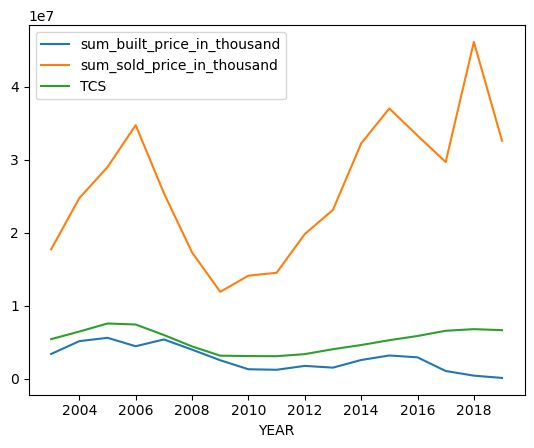

In [134]:
additional1.plot(x='YEAR');

### ***6.1 Findings:***
    - The sold_of_house line decreases following the trends of 2008 market crash and 2018 financial crisis.
    - Total residential construction spending and houses built from 2003 to 2019 appear to be stable, but the number of houses sold changes dramatically, this proves the sold_of_house increases drastically while built_of_house and TCS remain relatively the same is clear indicator of financial bubble. 

### **6.2 Checking the total sale price of residential buildings with the U.S. National Home Price Index (HPI) to see what is happening around the great financial crisis of 2008.**

In [135]:
%%bigquery additional2
WITH a AS (
SELECT EXTRACT(YEAR FROM DATE) AS year, EXTRACT(MONTH FROM DATE) AS month, CSUSHPISA AS home_price_index
FROM `ba775-teamproject-b1.teamproject.home_price_index`
ORDER BY DATE
),
b AS (
SELECT EXTRACT(YEAR FROM SALE_DATE) AS year, EXTRACT(MONTH FROM SALE_DATE) AS month, SUM(SALE_PRICE) AS total_saleprice
FROM `ba775-teamproject-b1.teamproject.nycdata`
WHERE BUILDING_CLASS_CATEGORY LIKE "%CONDO%"
OR BUILDING_CLASS_CATEGORY LIKE "%HOUSE%"
OR BUILDING_CLASS_CATEGORY LIKE "%HOME%"
OR BUILDING_CLASS_CATEGORY LIKE "%DWELLINGS%"
OR BUILDING_CLASS_CATEGORY LIKE "%APARTMENT%"
GROUP BY year, month
ORDER BY year, month
)

SELECT CONCAT(year, '-',month) AS year_month, home_price_index, 
        (total_saleprice/100000000) as total_saleprice_in_hundred_million
FROM(
SELECT a.year, a.month, home_price_index, total_saleprice
FROM a
JOIN b on a.year = b.year AND a.month = b.month
ORDER BY year, month) 

Downloading: 100%|██████████| 204/204 [00:01<00:00, 181.76rows/s]


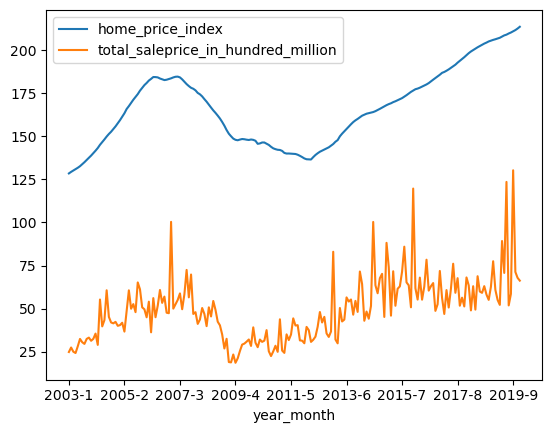

In [136]:
additional2.plot(x='year_month');

### ***6.2 Findings:***
    -The home price index (HPI) can track the selling price of residential units, but there will still be units that were sold at a much higher price. 
    -Investor should take HPI into consideration, but not rely entirely on it. 

### **Additional Analysis is COMPLETED.**
<br>

## **7. Conclusion**
<hr>

### Based on our analysis, we conclude that:
### 1. Real estate investors, developers, and families seeking houses in NYC, to make a more informed decision about their spending on tangible assets, should consider taking into account all variables including: 
     a. Gross Square Feet, 
     b. Sale Price, 
     c. Year Built, 
     d. Building Class Category
### 2. If the funding is sufficient, We advise investors to consider investing in buildings that fall under **Tax Class 3 Utilities Properties** for their significantly higher average price per square foot ($13,077) than others.     
#### We also advise investors to consider investing in **condos, facilities, and tax-class buildings** since 
    a. nearly 80% of highest-average-price-per-square-foot buildings are related to these types. 
    b. our analysis also suggests that from 2003 to 2019, these types of buildings' average price per square foot has been increasing, although sometimes drastically. However, this proves that once purchased, the value of condos, facilities and tax-class buildings have the potential to be appreciated compared to hotels and warehouses. 
#### 3. When it comes to how the age of the buildings affects their price, a general rule from our analysis is that investors should be looking at buildings that are **between 10 to 100 years old** for lack of price change in the short run. However, when considering different building categories, the "safe age" differs slightly: 
    a. Condos: between 23 and 42 years old. 
    b. Hotels: between 25 and 47 years old. 
    c. Warehouses: between 32 to 50 years old.
    d. Tax Class: between 4 to 22 years old, or after 96 years old.  
    e. Facilities: between 43 to 93 years old. 
#### 4. When it comes to the selection of neighborhoods, the ones with the highest volatilities in the selling price of buildings are **Breezy Point, Little Italy, Brighton Beach, Borough Park, and Jamaica Estates**, investors should stir away from these neighborhoods.
    * For other neighborhoods' volatilities, please refer to the tableau dashboard.
#### 5. Calculating from data from 2006 and data from 2008, we conclude that the neighborhoods that were most affected by the 2008 financial crisis were **Jamaica Estates, Chelsea, Midtown West, Coney Island, and Financial**. (*most affected suggesting the largest loss of value in average selling price per square foot*.) 
#### 6. From our additional analysis, we also conclude that: 
    a. Total Construction Spending on Residential Housing by Federal Reserve Economic Data should be considered by all investors who are spending on real estate. When checking against the price of total houses built and sold, it shows how logical the acutal dollar amount of houses built/sold is, and whether the market is making a mistake.
    b. The home price index is useful when tracking the selling price of residential units, but there will still be units that were sold at a much higher price from time to time. 

## **8. Conclusion: Summarized**
<hr>

#### *Based on our analysis, if we have to conclude our findings in one sentence:*
### Real estate investors or buyers who are looking for a house in NYC should be looking for condos, facilities, and tax-class buildings for a higher price per square foot and potential to appreciate, they should be seeking for buildings that are between 10 to 100 years old for the lack of price drop in short term, and they should avoid neighborhoods such as Breezy Point, Little Italy, Brighton Beach, Borough Park, and Jamaica Estates for the historical high volatilities in price, and avoid neighborhoods such Chelsea, Midtown West, Coney Island, and Financial for the largest drop of their housing price during the last financial crisis. They should also consider TCS data and HPI data from FRED.

### **Conclusion is COMPLETED.**

## **9. Dashboard**
<hr>

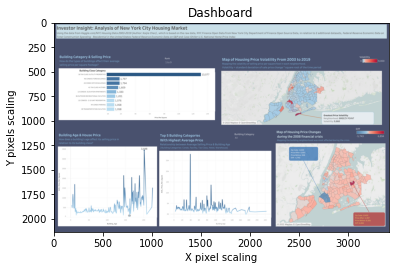

In [10]:
#Screen Shot of Dashboard.
from matplotlib import pyplot as plt
from matplotlib import image as mpimg
 
plt.title("Dashboard")
plt.xlabel("X pixel scaling")
plt.ylabel("Y pixels scaling")
 
image = mpimg.imread("Dashboard.png")
plt.imshow(image)
plt.show()

In [2]:
#To open dashboard image, please run this. 
from PIL import Image
myImage = Image.open("Dashboard.png")
myImage.show()

### To open dashboard using Tableau Public, please use the link below
###  __[Dashboard](https://public.tableau.com/app/profile/zheman.zhong/viz/BA775_Team1B/Dashboard1)__


## **10. Citation**
<hr>

### The volitality formula we used in 5.3 is from investopedia.com
###  __[Investopedia-Terms-Volitality](https://www.investopedia.com/terms/v/volatility.asp)__

### **Project ENDS here.**